In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import os
import os.path
import time
import skimage, skimage.io
import time
import copy

In [2]:
df = pd.read_csv('train.csv')

#### Convert Images to Grayscale and Resize 

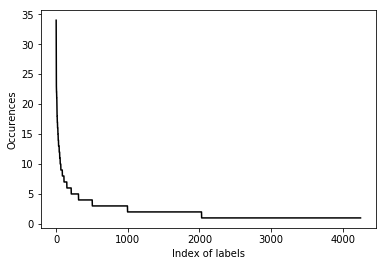

In [3]:
unique = pd.value_counts(df.Id)
num_classes_full = unique.values.shape[0]

plt.figure()
plt.plot(range(1,num_classes_full),unique.values[1:],'-k')
plt.xlabel('Index of labels')
plt.ylabel('Occurences')
plt.show()

In [4]:
print ("Classes:", num_classes_full)
print ("Images:",df.shape[0])

Classes: 4251
Images: 9850


In [5]:
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')
df = df.sort_values('occurrences',ascending=False)
df[:10]

,Image,Id,occurrences
1172,1e484732.jpg,new_whale,810
1230,200b53a2.jpg,new_whale,810
8688,e1eba938.jpg,new_whale,810
5080,842686a1.jpg,new_whale,810
5086,8441a59e.jpg,new_whale,810
5089,847238a3.jpg,new_whale,810
5105,84df4d6d.jpg,new_whale,810
5112,84eec364.jpg,new_whale,810
5119,8504db72.jpg,new_whale,810
5123,851a3114.jpg,new_whale,810


In [6]:
# find the most common aspect ratio
H = []
W = []
count = 0
folder = './data/train/'

for fname in os.listdir(folder):
    if fname[-3:] == 'jpg':
        img = skimage.io.imread(folder+fname)
        H.append(img.shape[0])
        W.append(img.shape[1])
        count += 1

H = np.array(H,dtype='float')
W = np.array(W,dtype='float')
A = H/W
unique, ret_counts = np.unique(A,return_counts=True)

In [7]:
def resize_images(folder1, folder2):
     #images = []
    for filename in os.listdir(folder1):
        img = cv2.imread(os.path.join(folder1,filename))
        chan = img.shape[-1]
        if chan==3:
            g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            new_img = cv2.resize(g_img,(224,224),interpolation=cv2.INTER_AREA)
        else:
             new_img = cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
        if new_img is not None:
            out_path = os.path.join(folder2,filename)
            cv2.imwrite(out_path,new_img)


Text(0,0.5,'Occurrences')

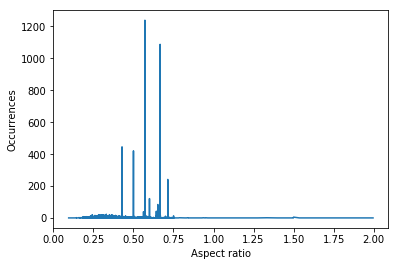

In [8]:
plt.figure()
plt.plot(unique,ret_counts)
plt.xlabel('Aspect ratio')
plt.ylabel('Occurrences')

The class 'new_whale' has the highest number of occurrences - 810. In summary, looking at the plots of the data distribution and aspect ratios we can now conclude that the data distribution is highly skewed and the images are of varying sizes. Many of the labels occur only once. This will make identifying the whales a challenging problem. Also, it would be a good idea to resize all the images to a uniform size

In [9]:
if not os.path.exists('data_gray'):
    os.mkdir('data_gray')
resize_images('data/train/','data_gray/')

#### Create a new data frame with selected data 

In [45]:
# throw away all the labels which have fewer than 10 images associated with them and all the new whales
my_df = df[(df.occurrences >= 10) & (df.Id != 'new_whale')]

my_df.head()

,Image,Id,occurrences
4175,6d82e3d0.jpg,w_1287fbc,34
1673,2c4813a1.jpg,w_1287fbc,34
5624,91b704dc.jpg,w_1287fbc,34
8424,db147df2.jpg,w_1287fbc,34
1670,2c3b34a3.jpg,w_1287fbc,34


In [12]:
my_df.nunique()

Image          979
Id              65
occurrences     17
dtype: int64

There are 65 whales with 10 occurences or more. The size of the output layer will hence be 65.

#### Split new data frame into training and validation data 

In [13]:
my_x = np.array(my_df['Image'])
my_x= 'data_gray/' + my_x

my_Y = np.array(my_df['Id'])

In [14]:
my_msk = np.random.rand(len(my_x)) < 0.75
my_x_train = my_x[my_msk]
my_Y_train = my_Y[my_msk]

my_x_val = my_x[~my_msk]
my_Y_val = my_Y[~my_msk]

In [15]:
print(f'{my_df.shape[0]} images have been split into {len(my_x_train)} training images and {len(my_x_val)} validation images')

979 images have been split into 755 training images and 224 validation images


#### Store training and validation into classwise folders 

In [16]:
import shutil

subset_path = 'data_subset'
subset_train_path = 'data_subset/train'
subset_val_path = 'data_subset/val'

if not os.path.exists(subset_path):
    os.mkdir(subset_path)
else:
    shutil.rmtree(subset_train_path)
    shutil.rmtree(subset_val_path)

if not os.path.exists(subset_train_path):    
    os.mkdir(subset_train_path)

if not os.path.exists(subset_val_path):
    os.mkdir(subset_val_path)

In [17]:
for folder in my_Y:
    path = subset_train_path + "/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

In [18]:
for folder in my_Y:
    path = subset_val_path + "/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

In [19]:
cnt = 0
gray_path = 'data_gray/'
for file in my_x_train:
    image = file.replace(gray_path,'')
    new_path = subset_train_path + "/" + my_Y_train[cnt] + "/" + image
    img = cv2.imread(file)
    cv2.imwrite(new_path,img)
    cnt = cnt + 1

In [20]:
cnt = 0

for file in my_x_val:
    image = file.replace(gray_path,'')
    new_path = subset_val_path + "/" + my_Y_val[cnt] + "/" + image
    img = cv2.imread(file)
    cv2.imwrite(new_path,img)
    cnt = cnt + 1

#### Extract Bottleneck Features and perform Transfer Learning - new notebook 

In [21]:
x = np.array(df['Image'])
x= 'data_gray/' + x

Y = np.array(df['Id'])

In [22]:
msk = np.random.rand(len(x)) < 0.75
x_train = x[msk]
Y_train = Y[msk]

x_val = x[~msk]
Y_val = Y[~msk]

In [23]:
full_path = 'data_full'
full_train_path = 'data_full/train'
full_val_path = 'data_full/val'

if not os.path.exists(full_path):
    os.mkdir(full_path)
else:
    shutil.rmtree(full_train_path)
    shutil.rmtree(full_val_path)

if not os.path.exists(full_train_path):    
    os.mkdir(full_train_path)

if not os.path.exists(full_val_path):
    os.mkdir(full_val_path)

In [24]:
for folder in Y:
    path = full_train_path + "/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

In [25]:
for folder in Y:
    path = full_val_path + "/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

In [26]:
cnt = 0
gray_path = 'data_gray/'
for file in x_train:
    image = file.replace(gray_path,'')
    new_path = full_train_path + "/" + Y_train[cnt] + "/" + image
    img = cv2.imread(file)
    cv2.imwrite(new_path,img)
    cnt = cnt + 1

In [27]:
cnt = 0

for file in x_val:
    image = file.replace(gray_path,'')
    new_path = full_val_path + "/" + Y_val[cnt] + "/" + image
    img = cv2.imread(file)
    cv2.imwrite(new_path,img)
    cnt = cnt + 1

In [28]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
pt_model_path = 'pt_model.h5'  
train_data_dir = subset_train_path  
validation_data_dir = subset_val_path  
   
# number of epochs to train top model  
epochs = 50  
# batch size used by flow_from_directory and predict_generator  
train_batch_size = 16  
val_batch_size = 4  

In [40]:
from keras.preprocessing.image import ImageDataGenerator

train_idg = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2)

train_gen = train_idg.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size = train_batch_size
)

n_classes = train_gen.classes

val_idg = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2)

val_gen = val_idg.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size = val_batch_size
)


Found 755 images belonging to 65 classes.
Found 224 images belonging to 65 classes.


In [30]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

In [41]:
input_shape = (img_width, img_height,3)

nclass = len(train_gen.class_indices)

base_model = applications.ResNet50(weights='imagenet', 
                                include_top=False, 
                                input_shape=input_shape)
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

/home/Spartacus/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 65)                133185    
Total params: 23,720,897
Trainable params: 133,185
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
CUDA_VISIBLE_DEVICES = 1

In [43]:
checkpoint = ModelCheckpoint(pt_model_path, monitor='acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=15)

callbacks_list = [checkpoint, early] #early

history = model.fit_generator(train_gen, 
                              epochs=epochs,
                              steps_per_epoch=(len(my_x_train)/train_batch_size),
                              shuffle=True, 
                              verbose=True,
                              validation_data = val_gen,
                              validation_steps=(len(my_x_val)/val_batch_size),
                              callbacks=callbacks_list)

Epoch 1/50
48/47 [==============================] - 64s 1s/step - loss: 4.6941 - acc: 0.0169 - val_loss: 4.6611 - val_acc: 0.0179

Epoch 00001: acc improved from -inf to 0.01722, saving model to pt_model.h5
Epoch 2/50
48/47 [==============================] - 54s 1s/step - loss: 4.4386 - acc: 0.0404 - val_loss: 4.5729 - val_acc: 0.0134

Epoch 00002: acc improved from 0.01722 to 0.04106, saving model to pt_model.h5
Epoch 3/50
48/47 [==============================] - 54s 1s/step - loss: 4.2594 - acc: 0.0443 - val_loss: 4.5448 - val_acc: 0.0268

Epoch 00003: acc improved from 0.04106 to 0.04503, saving model to pt_model.h5
Epoch 4/50
48/47 [==============================] - 54s 1s/step - loss: 4.1915 - acc: 0.0339 - val_loss: 4.4425 - val_acc: 0.0223

Epoch 00004: acc did not improve from 0.04503
Epoch 5/50
48/47 [==============================] - 54s 1s/step - loss: 3.9896 - acc: 0.0703 - val_loss: 4.4163 - val_acc: 0.0402

Epoch 00005: acc improved from 0.04503 to 0.07152, saving model t

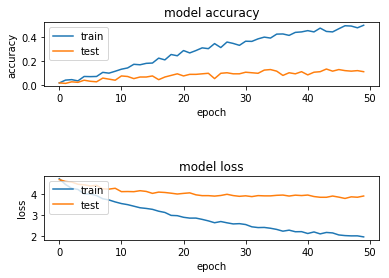

In [44]:
plt.figure(1)  

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

# summarize history for accuracy  

plt.subplot(311)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(313)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 